
# Zcash Observatory data

Mitchell Krawiec-Thayer and Pranav Thirunavukkarasu

June 2020

Observatory R & D at Insight supported by the Zcash Foundation


## Parameters

In [1]:
path_to_files = '.'

## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os;

## Import data

In [3]:
# What are the nearby directories
folders = [x[0] for x in os.walk(path_to_files)]

In [4]:
# global_df = pd.DataFrame()
node_names = list()
first_time = 1
for f in range(len(folders)):
    this_folder_raw = folders[f]
    if not (this_folder_raw[0:3] == './.' or this_folder_raw == '.'):
        node_name = this_folder_raw[2::]
        node_names.append(node_name)
        file_name = os.path.join(this_folder_raw,'inv_v1.csv')
        this_df = pd.read_csv(file_name)
        
        # Some feature engineering
        min_time = this_df.groupby('Hash').min()
        min_time = min_time.rename(columns={"Validated_Time": node_name+"_min", "Peer_IP": "min_IP", "Hash":'block_hash'})
        max_time = this_df.groupby('Hash').max()
        max_time = max_time.rename(columns={"Validated_Time": node_name+"_max", "Peer_IP": "max_IP", "Hash":'block_hash'})
        single_node_combined = pd.concat([min_time, max_time], axis=1)
        single_node_combined[node_name+'_prop_time'] = single_node_combined[node_name+'_max']-single_node_combined[node_name+'_min']
        single_node_combined = single_node_combined.filter(['block_hash', node_name+"_min", node_name+"_max",node_name+"_prop_time"], axis=1)
        
        if first_time:
            global_df = single_node_combined
            first_time = 0
        else:
            global_df = pd.concat([global_df,single_node_combined], axis=1, sort=False)
global_df.head()

,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time
000000000000b86df2619ffbde1d3de76bdf1cc9c73b4acc91dccad6f234ec71,1.590722e+09,1.590722e+09,27.129,1.590722e+09,1.590722e+09,119.911,1.590722e+09,1.590722e+09,26.983,1.590722e+09,1.590722e+09,27.092
000000000000bc65600076a474767b0201c02fac53adb217dcafb8f44a3de6e4,1.590754e+09,1.590754e+09,12.173,1.590754e+09,1.590754e+09,12.125,1.590754e+09,1.590754e+09,12.103,1.590754e+09,1.590754e+09,8.697
000000000000c32bff2dcb5497f93438548bf10ef1e7ac541b0b0e81a100e1f1,1.590774e+09,1.590774e+09,61.857,1.590774e+09,1.590774e+09,187.656,1.590774e+09,1.590774e+09,61.846,1.590774e+09,1.590774e+09,162.400
0000000000016608d92021f3056e25742fc063ff7409fbd80f9cf0d290516a16,1.590711e+09,1.590711e+09,5.704,1.590711e+09,1.590711e+09,3.020,1.590711e+09,1.590711e+09,5.696,1.590711e+09,1.590711e+09,4.580
000000000002dd1be009ee3ee605f3c109ed3cc5514772f1169a7766e94bf77b,1.590719e+09,1.590720e+09,269.665,1.590719e+09,1.590719e+09,3.149,1.590719e+09,1.590720e+09,269.792,1.590719e+09,1.590719e+09,4.153


## Feature engineering

In [37]:
prop_list = list()
min_list = list()
max_list = list()
for h in range(len(global_df)):
    min_stamps = list()
    max_stamps = list()
    keep_data = 1
    for loc_ind in range(len(node_names)):
        min_val_col = global_df[node_names[loc_ind]+"_min"]
        min_val = min_val_col[h]
        min_stamps.append(min_val)
        max_val_col = global_df[node_names[loc_ind]+"_max"]
        max_val = max_val_col[h]
        max_stamps.append(max_val)
        
    global_min = min(min_stamps)
    min_list.append(global_min)
    global_max = max(max_stamps)
    max_list.append(global_max)
    global_prop = global_max - global_min
    prop_list.append(global_prop)
    
global_df['global_min'] = min_list
global_df['global_max'] = max_list
global_df['global_prop_time'] = prop_list

keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
toss
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep


keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
toss
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep
keep


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Strip out blocks that were not fully observed

In [25]:
global_df = global_df[global_df['global_prop_time']>0]

## Review data

Look at global propagation time

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

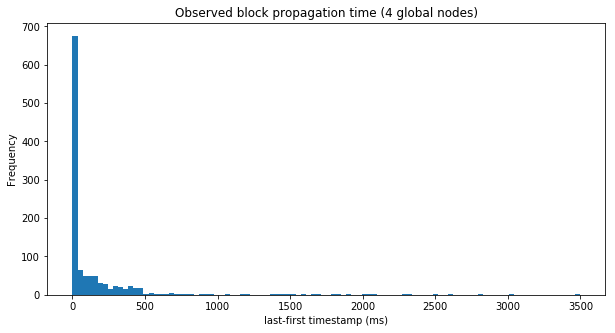

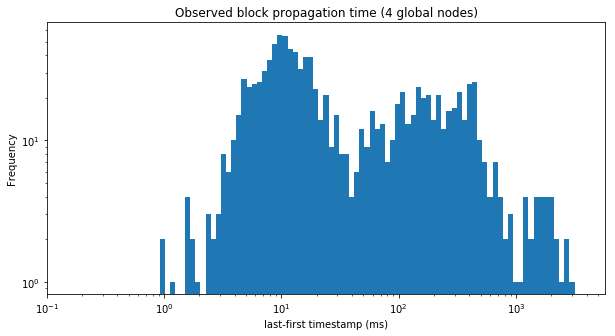

In [26]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=100)
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.logspace(np.log10(min(global_df['global_prop_time'][global_df['global_prop_time']>0])),np.log10(max(global_df['global_prop_time'])), 100) );plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
#plt.xlim(min(global_df['global_prop_time'][global_df['global_prop_time']>0]),max(global_df['global_prop_time']))
plt.title('Observed block propagation time (4 global nodes)')

Zoom in on speedy blocks

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

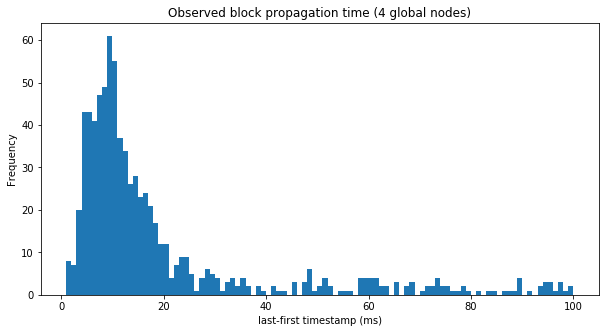

In [27]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.linspace(1,100,100))
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

Check out some fast and slow blocks

In [30]:
global_df.sort_values(by='global_prop_time').head()

,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,global_min,global_max,global_prop_time
0000000001f247418b3355fd8079f956aa78fd9d00eb7fd4a918c5eb124969c6,1.590755e+09,1.590755e+09,0.000,1.590755e+09,1.590755e+09,0.000,NaN,NaN,NaN,1.590755e+09,1.590755e+09,0.000,1.590755e+09,1.590755e+09,0.165
000000000084537c73dc6318dc21da34fb8ee18a2c0473cc0846c98380e0bb74,1.590716e+09,1.590716e+09,0.872,1.590716e+09,1.590716e+09,0.871,1.590716e+09,1.590716e+09,0.717,1.590716e+09,1.590716e+09,0.897,1.590716e+09,1.590716e+09,0.980
00000000016ce21bde209faf432687f24c56f66f72f70ccf4b6cc8eb68248dc2,1.590701e+09,1.590701e+09,0.716,1.590701e+09,1.590701e+09,0.963,1.590701e+09,1.590701e+09,0.713,1.590701e+09,1.590701e+09,0.421,1.590701e+09,1.590701e+09,0.990
000000000121e410e24f17864852861222835d48e5f322bcd8480368dea2ecd1,1.590706e+09,1.590706e+09,0.893,1.590706e+09,1.590706e+09,0.625,1.590706e+09,1.590706e+09,0.918,1.590706e+09,1.590706e+09,1.038,1.590706e+09,1.590706e+09,1.142
000000000247fe90f20e7b1e428cdae6ed9d55f463e9a29f67860cda6ea4f031,1.590701e+09,1.590701e+09,0.524,1.590701e+09,1.590701e+09,1.513,1.590701e+09,1.590701e+09,0.969,1.590701e+09,1.590701e+09,0.769,1.590701e+09,1.590701e+09,1.513


In [31]:
global_df.sort_values(by='global_prop_time').tail()

,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,global_min,global_max,global_prop_time
0000000001add0e0c44b0394cfce2696477610ec32c8b712c00fe38d7d7c206c,1.590757e+09,1.590757e+09,8.938,1.590757e+09,1.590759e+09,2486.880,1.590757e+09,1.590757e+09,8.918,1.590757e+09,1.590757e+09,4.406,1.590757e+09,1.590759e+09,2486.896
00000000016d0d3ff3b1ad60e158070b04391ae57e7fcbcdc4198a71c3399ca5,1.590757e+09,1.590757e+09,8.086,1.590757e+09,1.590759e+09,2603.331,1.590757e+09,1.590757e+09,8.095,1.590757e+09,1.590757e+09,2.265,1.590757e+09,1.590759e+09,2603.357
00000000010c8bf4ad56a3aa02b46acb7e11d0cbbc9ed7bc9e97d9c416438f94,1.590757e+09,1.590757e+09,16.307,1.590757e+09,1.590759e+09,2798.421,1.590757e+09,1.590757e+09,16.398,1.590757e+09,1.590757e+09,2.801,1.590757e+09,1.590759e+09,2798.421
00000000025b45c144ea5ff636eb2fb16efa63b3e6e32e0a92d3fa9b10b49549,1.590756e+09,1.590756e+09,13.772,1.590756e+09,1.590759e+09,3008.781,1.590756e+09,1.590756e+09,15.214,1.590756e+09,1.590756e+09,2.087,1.590756e+09,1.590759e+09,3008.781
000000000023f66bddc3710f0be6b0ec8c90d30d971f9636688d3e7aadd59937,1.590756e+09,1.590756e+09,422.472,1.590756e+09,1.590759e+09,3495.512,1.590756e+09,1.590756e+09,422.766,1.590756e+09,1.590756e+09,40.694,1.590756e+09,1.590759e+09,3495.512


## To-Do

Require data from all 4 nodes

Join with block height
^ then add real blocktime

Join with block size

False